# Analisis del problema
El objetivo principal de este análisis es predecir el precio de cierre del Bitcoin en los próximos días. Para lograrlo, se utilizarán datos históricos que incluyen precios de apertura, cierre, máximos, mínimos, volumen y capitalización de mercado. La predicción del precio es de gran interés debido a la naturaleza volátil de las criptomonedas, lo que permite identificar tendencias que podrían ser útiles para decisiones financieras.

# Entendimiento de los datos
`Date`: Tipo object. Esta columna almacena las fechas correspondientes a cada registro de datos. Será importante para el análisis temporal, ya que permite asociar los valores de precios y volúmenes a momentos específicos en el tiempo.

`Open`: Tipo float64. Representa el precio de apertura del Bitcoin en un día específico. Es crucial para entender el comportamiento de precios al inicio del día.

`High`: Tipo float64. Indica el precio más alto alcanzado por el Bitcoin durante el día. Esta columna puede ser útil para analizar la volatilidad diaria.

`Low`: Tipo float64. Refleja el precio más bajo registrado en el día. Junto con la columna "High", ofrece una medida del rango de precios en un día.

`Close`: Tipo float64. Representa el precio de cierre del Bitcoin al final del día, el cual suele ser el valor más relevante para predicciones, ya que se utiliza como referencia diaria en los mercados financieros.

`Volume`: Tipo object. Almacena el volumen de transacciones en un formato de texto, pero debería ser convertido a formato numérico. El volumen es útil para analizar la actividad del mercado y puede influir en las variaciones de precios.

`Market Cap`: Tipo object. Indica la capitalización de mercado del Bitcoin en formato de texto. Al igual que con el volumen, es necesario convertirla a formato numérico para el análisis. La capitalización es una medida importante para entender la escala del valor de mercado del activo.

# Exploracion de datos

## Librerias

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Load dataset
df = pd.read_csv('../datasets/bitcoin.csv')

# Preprocess data
df['Date'] = pd.to_datetime(df['Date'])
df['Volume'] = df['Volume'].replace('-', np.nan).str.replace(',', '').astype(float)
df['Market Cap'] = df['Market Cap'].replace('-', np.nan).str.replace(',', '').astype(float)

# Order by date
df = df.sort_values(by='Date')
df = df.set_index('Date')
# Fill missing values with median
df['Volume'] = df['Volume'].fillna(df['Volume'].median())
df['Market Cap'] = df['Market Cap'].fillna(df['Market Cap'].median())
print(df.isnull().sum())


Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64


In [9]:
# Check data range
print(df.head(5))
print(df.tail(5))

              Open    High     Low   Close      Volume    Market Cap
Date                                                                
2013-04-28  135.30  135.98  132.10  134.21  45301400.0  1.500520e+09
2013-04-29  134.44  147.49  134.00  144.54  45301400.0  1.491160e+09
2013-04-30  144.00  146.93  134.05  139.00  45301400.0  1.597780e+09
2013-05-01  139.00  139.89  107.72  116.99  45301400.0  1.542820e+09
2013-05-02  116.38  125.60   92.28  105.21  45301400.0  1.292190e+09
               Open     High      Low    Close        Volume    Market Cap
Date                                                                      
2017-07-27  2538.71  2693.32  2529.34  2671.78  7.891040e+08  4.181650e+10
2017-07-28  2679.73  2897.45  2679.73  2809.01  1.380100e+09  4.414440e+10
2017-07-29  2807.02  2808.76  2692.80  2726.45  8.037460e+08  4.624670e+10
2017-07-30  2724.39  2758.53  2644.85  2757.18  7.059430e+08  4.489070e+10
2017-07-31  2763.24  2889.62  2720.61  2875.34  8.605750e+08  4.553

In [10]:
y = df['Close']
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


# Modelo de Machine Learning


In [12]:
# Find best parameters
bestAIC = np.inf
bestParms = None
bestSeasonalParms = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit(disp=False)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < bestAIC:
                bestAIC = results.aic
                bestParms = param
                bestSeasonalParms = param_seasonal
        except:
            continue

print('Best ARIMA{}x{}12 - AIC:{}'.format(bestParms, bestSeasonalParms, bestAIC))


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:25149.9477472001
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:23118.211349850986
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:19183.48504273957
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:19000.01845596586
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:19107.73431184607
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:19076.961250553453
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:19012.851601251932
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:19002.011330274734
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:23078.033695609538
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:21228.937716561915
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:17818.09816614497
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:17690.531805763756
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:17784.194066048876
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:17764.785498790145
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:17711.812425812735
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:17692.276903285812
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:15655.280029807807
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:15546.82527869902

In [13]:
# Select best model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(disp=False)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0202      0.010     -2.035      0.042      -0.040      -0.001
ma.S.L12      -1.0000     11.979     -0.083      0.933     -24.479      22.479
sigma2      1397.1875   1.67e+04      0.083      0.933   -3.14e+04    3.42e+04


# Evaluaciones

Predicción para 2017-08-01 00:00:00: 2877.5616776425386


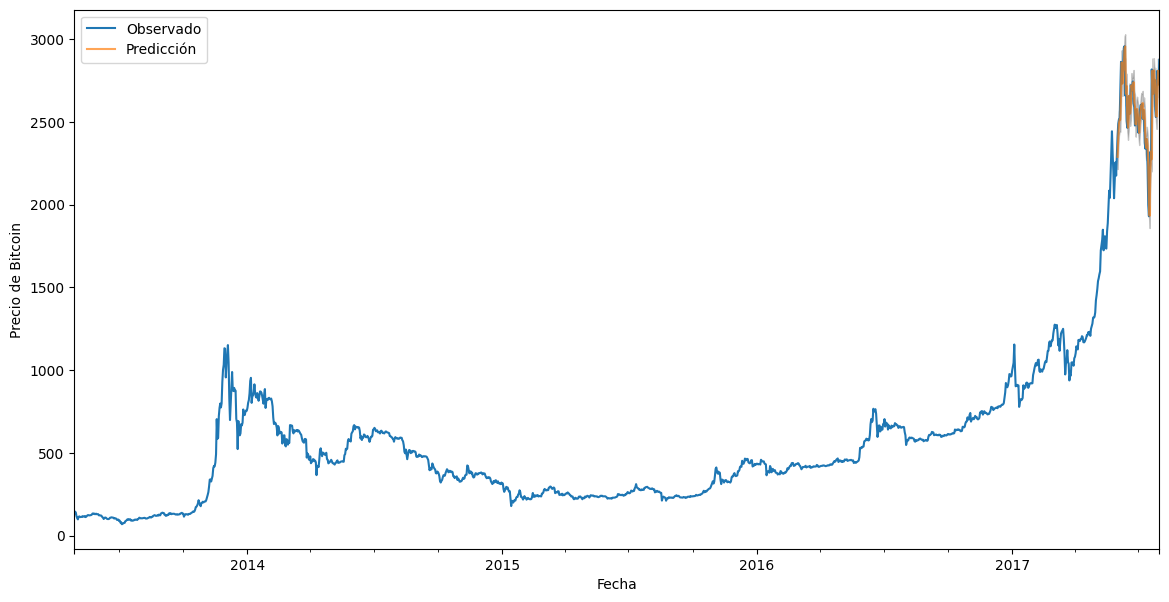

In [14]:

predict_date = pd.to_datetime('2017-08-01')  # Cambia a la fecha que desees

# Validate if the date is in the future and outside the historical data
if predict_date > y.index[-1]:
    steps = (predict_date - y.index[-1]).days
    forecast = results.get_forecast(steps=steps)
    prediccion = forecast.predicted_mean.iloc[-1]
    print(f'Predicción para {predict_date}: {prediccion}')
else:
    print(f'La fecha {predict_date} está dentro de los datos históricos.')

# Create forecast plot
pred = results.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2013':].plot(label='Observado')
pred.predicted_mean.plot(ax=ax, label='Predicción', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio de Bitcoin')
plt.legend()
plt.show()

# Resultados
El análisis muestra que el coeficiente ma.L1 es significativo, indicando que hay un ligero impacto a corto plazo en la predicción del precio del Bitcoin. Sin embargo, el componente estacional ma.S.L12 y la varianza del error (sigma2) no son significativos, lo que sugiere que no hay evidencia suficiente de que la estacionalidad o el ruido influyan en las predicciones. En general, el modelo capta algunos patrones a corto plazo, pero requiere más ajustes o la inclusión de otras variables para mejorar la precisión predictiva.